In [608]:
import numpy as np
import matplotlib.pyplot as plt

On génére 1000 valeurs de temps qui varient de 0 a 10 s et on garde le pas qu'on donne : 

In [609]:
tps = np.linspace(0, 10, 1000, retstep = True)
temps = tps[0]
pas = tps[1]

On crée une fonction permettant de générer un signal sinusoïdal dont l'amplitude et la fréquence augmentent en fonction du temps de manière lineare:

In [610]:
def sinusoidal(temps, amplitude_init, pulsation_init):
    
    amplitude = amplitude_init*temps
    pulsation = pulsation_init*temps
    
    signal = amplitude*np.sin(pulsation*temps)
    return signal

On va utiliser cette fonction pour créer un signal sur une plage temporelle d'une seconde avec la même fréquence d'échantillonnage que le tableau de temps généré au début.

Pour ça, on a besoin de générer un tableau de temps qui va de 0 a 1s avec le même pas que dans le tableau de temps précédant :

In [611]:
temps1 = temps[0:100]

On définit l'amplitude et la fréquence initiales de façon que notre signal de 0 a 1s, contienne ~5 passages par un maximum local: 

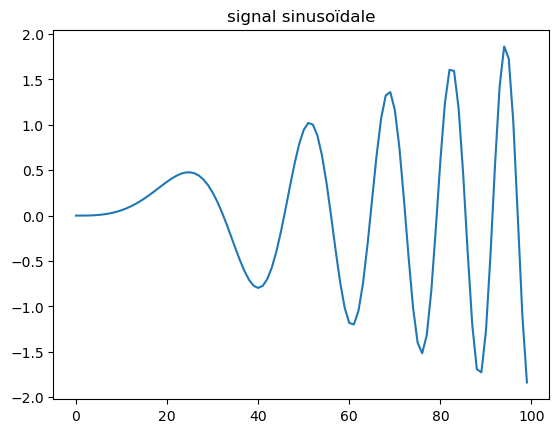

In [612]:
amp_init = 2
puls_init = 30 # en rad/s

signal = sinusoidal(temps1, amp_init, puls_init)
    
plt.plot(signal)
plt.title('signal sinusoïdale')
plt.show()

La fréquence d'échantillonnage de notre signal est le pas:

In [613]:
print(pas)

0.01001001001001001


En Hz (combien de points on a en 1 seconde) :

In [614]:
print(1/pas)

99.9


Connaissant la fréquence d'échantillonnage, on peut générer un tableau de frequences de Fourier correspondant à notre plage temporelle:

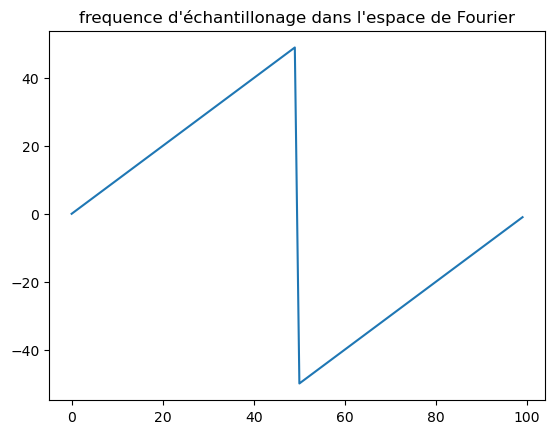

In [615]:
frequence1 = np.fft.fftfreq(np.size(temps[0:100]), pas)

plt.plot(frequence1)
plt.title("frequence d'échantillonage dans l'espace de Fourier")
plt.show()

On remarque la forme symétrique de la fonction nécessaire pour calculer la transformée de Fourier numériquement.

On calcule aussi la transformée de Fourier de notre signal:

In [616]:
signal_fourier = np.fft.fft(signal)

On trace la partie réelle en fonction de la fréquence:

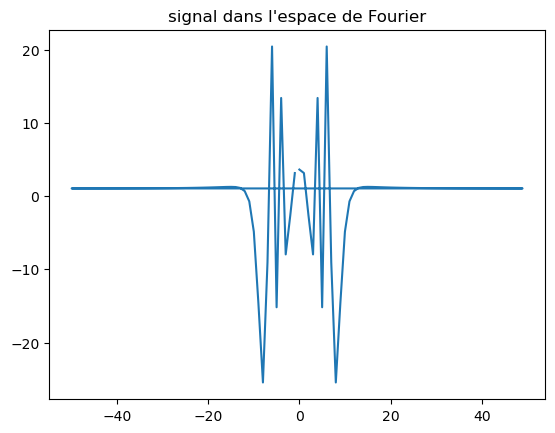

In [617]:
plt.plot(frequence1, np.real(signal_fourier))
plt.title("signal dans l'espace de Fourier")
plt.show()

On remarque encore la forme symetrique.

En utilisant les valeurs de fréquences positives on défine une focntion permetant de génñerer la densité spectrale de pussance (PSD) d'un bruit coloré sous la dorme d'une loi de puissance : 

In [618]:
def psd(frequence, gamma):
    p = ((frequence[frequence>0])/10)**(gamma) + 1
    return p

On trace un PSD avec gamma < -1:

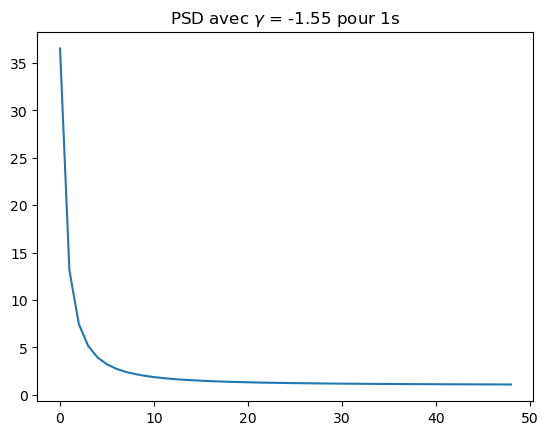

In [619]:
gamma = -1.55
dens1 = psd(frequence1, gamma)
plt.plot(dens1)
plt.title("PSD avec $\gamma$ = -1.55 pour 1s")
plt.show()

C'est la forme attendue d'un bruit coloré dans l'espace de Fourier, i.e, la densité spectrale de puissance d'un bruit coloré. Comme on a vu avant, pour faire la transformée de Fourier inverse, on a besoin (numeriquement parlant) que la fonction soit symetrique. C'est pour ça qu'on ajoute le 0 et on "ajoute" la fonction "miroir". On défini une fontion qui fait ça:

In [620]:
def miroir(densite):
    densite = np.insert(densite, 0,  0)
    densite = np.concatenate((densite, np.flip(densite)))
    return densite

On utilise la fonction avec nos données:

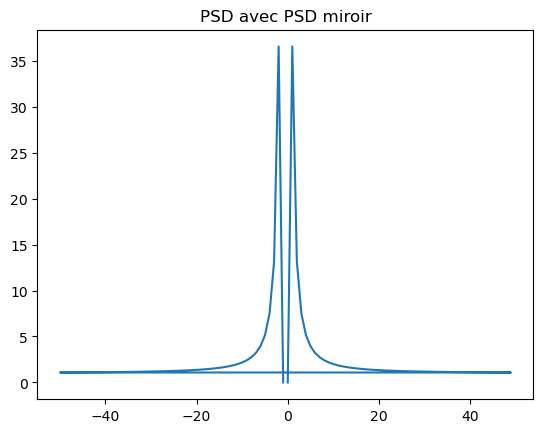

In [621]:
dens1 = psd(frequence1, gamma)
dens1 = miroir(dens1)
plt.plot(frequence1, dens1)
plt.title("PSD avec PSD miroir")
plt.show()

Un fois que l'on a créé un bruit coloré dans l'espace de Fourier, on va créer un autre bruit coloré dans l'espace de Fourier mais avec la "longueur" de toute notre prise de données, i.e. 10 s en lieu de juste 1s :  

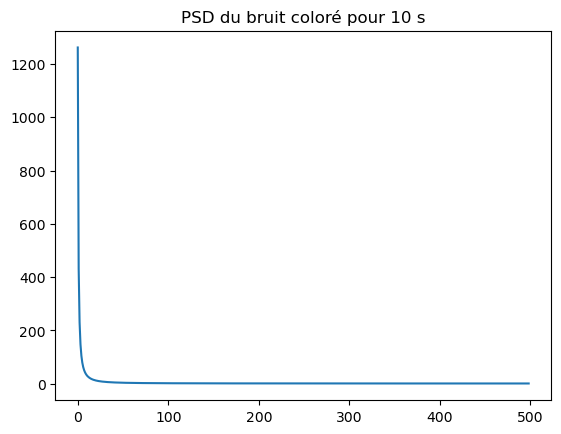

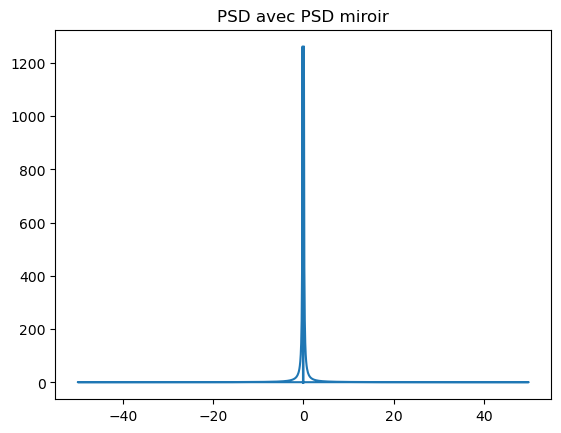

In [622]:
frequence = np.fft.fftfreq(np.size(temps), pas)

dens = psd(frequence, gamma)
plt.plot(dens)
plt.title("PSD du bruit coloré pour 10 s")
plt.show()

dens = miroir(dens)
plt.plot(frequence, dens)
plt.title("PSD avec PSD miroir")
plt.show()

Maintenant il faut passer de l'espace de Fourier à l'espace réel pour obtenir le bruit coloré :

In [623]:
def bruit(dens):
    bruit_blanc = np.random.normal(0,1,1000)
    fourier_blanc = np.fft.fft(bruit_blanc)
    
    fourier_color = fourier_blanc*np.sqrt(dens)
    bruit_color = np.real(np.fft.ifft(fourier_color))
    
    return bruit_color

On crée une fonction permetant de rajouter le signal de façon aléatoire dans le bruit et comme ça obtenir un vecteur de données simules d (données "mesurées" modelisées).

In [624]:
pos = np.random.randint(1000-100)

def signalsurbruit(densite, signal, position):
    bruit_color = bruit(densite)
    bruit_color[position:position+np.size(signal)] += signal
    
    return bruit_color

En utilisant cette fonction on a notre vecteur de données simulés:

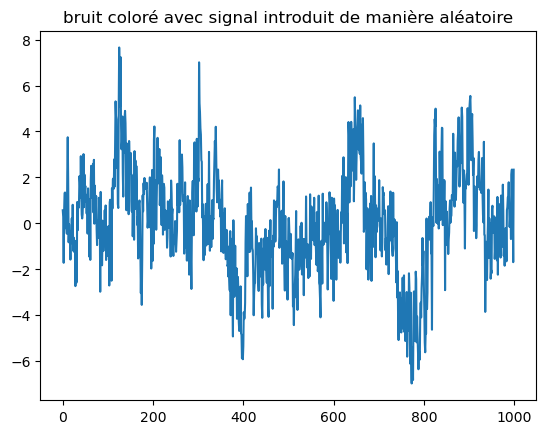

In [625]:
signal_bruit = signalsurbruit(dens, signal, pos)
plt.plot(signal_bruit)
plt.title("bruit coloré avec signal introduit de manière aléatoire")
plt.show()

On essaie une amplitude plus grande pour vérifier qu'on peut voir le signal :

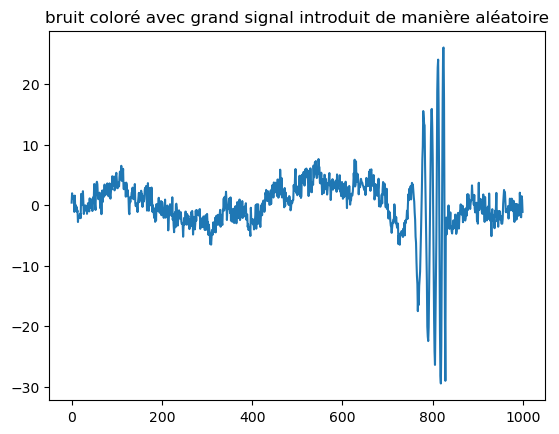

In [626]:
big_amp_init = 30

big_signal = sinusoidal(temps1, big_amp_init, puls_init)

big_signal_bruit = signalsurbruit(dens,big_signal,pos)

plt.plot(big_signal_bruit)
plt.title("bruit coloré avec grand signal introduit de manière aléatoire")
plt.show()

Une fois on a notre signal dans du bruit, on va créer le filtre. Pour ça on a besoin d'un model d'un signal et d'un model du bruit, comme on avait vu avec le signal simple et le bruit blanc gaussien. 

On commence en modelisant une signal de la même manière qu'avant. On peut changer l'amplitude mais la pulsation et les pas entre points doit être pareil que le signal "mesuré":

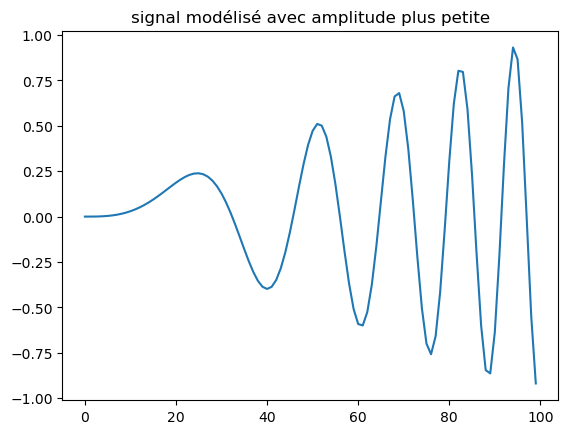

In [627]:
amp_init_model = 1
signal_model = sinusoidal(temps1, amp_init_model, puls_init)

plt.plot(signal_model)
plt.title("signal modélisé avec amplitude plus petite")
plt.show()

Dans ce cas là on a decidé de mettre une amplitude un peu plus grande que celle du signal "mesuré"

Pour modeliser le bruit, on utilise la fonction bruit(densite) pour générer du bruit coloré plusieurs fois afin d'estimer la matrice de covariance du bruit.
On crée une fonction qui calcule la inverse de la matrice de covariance de 1000 réalisations du bruit en 1s pour l'utiliser comme filtre:

In [628]:
def covariance(densite, temps):
    Cn = np.zeros((100,100))
    for i in range(1000):
        bruit_color = bruit(densite)
        Cn += np.dot(np.transpose(bruit_color[None, 0:100]), bruit_color[None, 0:100])
    Cn /= np.size(temps)
    cov = np.linalg.inv(Cn)
    return cov, Cn

In [629]:
cov, Cn = covariance(dens, temps)

On vérifie des propiétés de ces matrices: 

In [630]:
if (Cn.all() == np.transpose(Cn).all()):
    print("La matrice de covariance est égal à la matrice de covariance transposée")

La matrice de covariance est égal à la matrice de covariance transposée


In [631]:
I = np.identity(100)
prod = np.dot(Cn,cov)
prod = prod.astype(int)

if prod.all() == I.all():
    print("La matrice de covariance fois son inverse donne l'identité")

La matrice de covariance fois son inverse donne l'identité


Donc, notre filtre devient:

In [632]:
filtre = np.dot(cov, signal_model)

On définit comme dans la partie du signal simple une fonction qui nous permet de faire le produit scalaire entre le filtre et le vrai signal pour trouver les corrélations croisées entre eux :

In [633]:
def cross(ymodel,ysig):
        sizemod = np.size(ymodel)
        sizesig = np.size(ysig)
        
        prod = []
    
        for i in range(sizesig-sizemod):
            p = np.dot(ymodel,ysig[i:(i+sizemod)])
            prod.append(p)
        return prod

On fait les corrélations croisées entre le modèle et les données (signal+bruit):

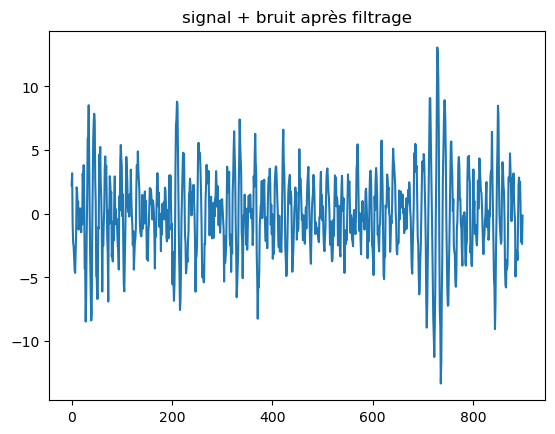

In [634]:
prodat = cross(filtre, signal_bruit)
plt.plot(prodat)
plt.title("signal + bruit après filtrage")
plt.show()

On crée deux fonction pour calculer et plot les 1000 réalisations de bruit filtrés, leur forme et leur deviation standar moyenne:

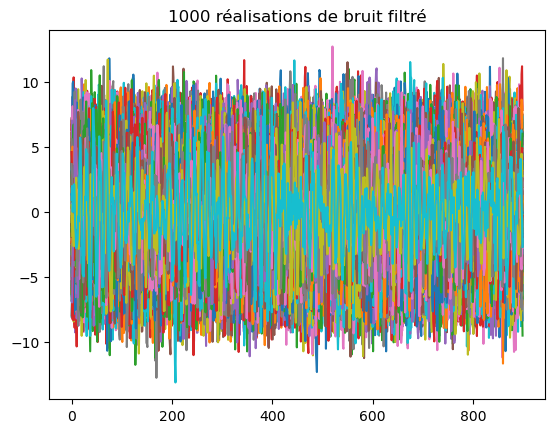

In [635]:
def bruitfiltre(densite,filtre):
    #plt.figure()
    bruit_filtre = np.zeros(900)
    devbr = 0
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        bruit_filtre += prodbruit
        dev = np.std(prodbruit)
        devbr+= dev
    bruit_filtre = bruit_filtre/1000
    devbr = devbr/1000
    return bruit_filtre, devbr

def bruitfiltreplot(densite,filtre):
    plt.figure()
    bruit_filtre = np.zeros(900)
    for i in range(1000):
        bruit_color = bruit(densite)
        prodbruit = cross(filtre, bruit_color)
        plt.title("1000 réalisations de bruit filtré")
        plt.plot(prodbruit)
    plt.show()
    return bruit_filtre
    

bruit_filtre, devbr = bruitfiltre(dens,filtre)
plot_bruit_filtre = bruitfiltreplot(dens,filtre)

Avec la deviation standar du bruit filtré et les données mesurés filtrés on peut maintenant calculer le SNR

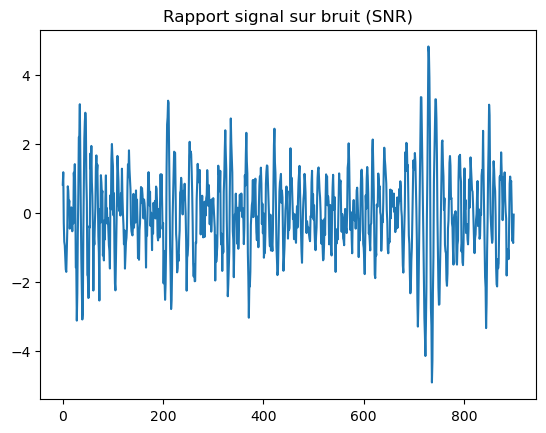

In [636]:
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

On cherche la position du maximum du SNR et on considère une détection si SNR > 3

In [637]:
def position_SNR_max(SNR):
    
    if np.max(SNR)<3:
        print("Pas de signal détecté")
        return None
    
    index = np.argmax(SNR)
    
    return index

Dans la vie réelle on ne saurait pas où se trouve le signal, mais ici on le sait. On peut comparer la position trouvé avec la position où on a introduit le signal et on vérifie que c'est la même:

In [638]:
position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

la position trouvé avec le filtre est :  729
la position aléatoire où on avait mis la signal dans le bruit est :  729


On fait quelques test pour étudier l'impact de la pente $\gamma$ de la PSD de notre bruit sur le SNR de détection de notre signal:

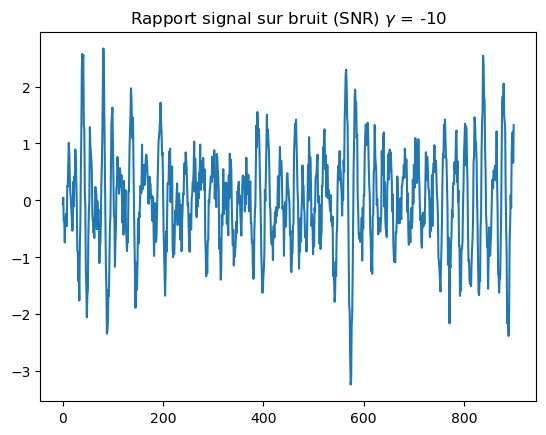

Pas de signal détecté
la position trouvé avec le filtre est :  None
la position aléatoire où on avait mis la signal dans le bruit est :  729


In [639]:
gamma = -10
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = -10")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

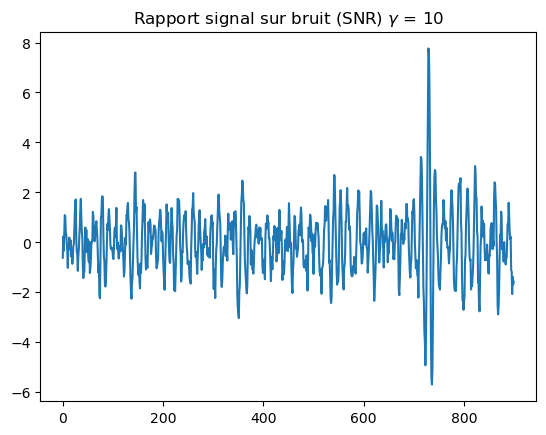

la position trouvé avec le filtre est :  729
la position aléatoire où on avait mis la signal dans le bruit est :  729


In [640]:
gamma = 10
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = 10")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

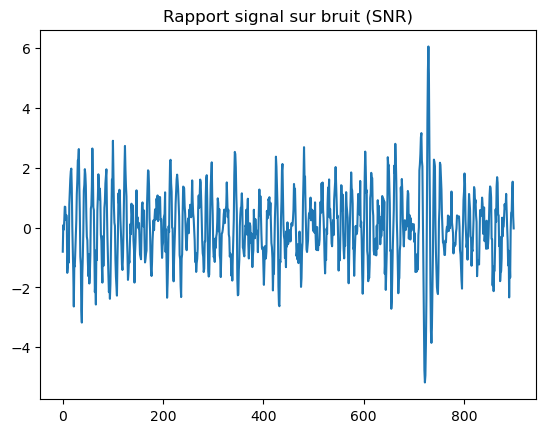

la position trouvé avec le filtre est :  729
la position aléatoire où on avait mis la signal dans le bruit est :  729


In [641]:
gamma = -1
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR)")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

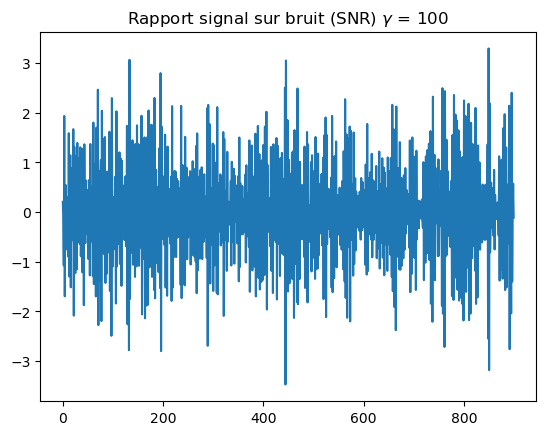

la position trouvé avec le filtre est :  849
la position aléatoire où on avait mis la signal dans le bruit est :  729


In [642]:
gamma = 100
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = 100")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)

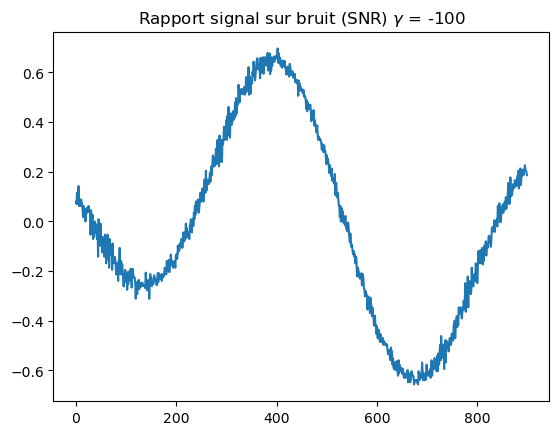

Pas de signal détecté
la position trouvé avec le filtre est :  None
la position aléatoire où on avait mis la signal dans le bruit est :  729


In [643]:
gamma = -100
dens = psd(frequence, gamma)
dens = miroir(dens)
signal_bruit = signalsurbruit(dens, signal, pos)
cov, Cn = covariance(dens, temps)
filtre = np.dot(cov, signal_model)
prodat = cross(filtre, signal_bruit)
bruit_filtre, devbr = bruitfiltre(dens,filtre)
SNR = prodat/devbr
plt.plot(SNR)
plt.title("Rapport signal sur bruit (SNR) $\gamma$ = -100")
plt.show()

position = position_SNR_max(SNR)
print("la position trouvé avec le filtre est : ", position)
print("la position aléatoire où on avait mis la signal dans le bruit est : ", pos)